In [37]:
#https://www.quantstart.com/articles/Backtesting-An-Intraday-Mean-Reversion-Pairs-Strategy-Between-SPY-And-IWM/
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cointegration_mult as mult
import Cointegration as coint

importlib.reload(coint)
importlib.reload(mult)

<module 'cointegration_mult' from 'D:\\trades\\pairs_trading_b3\\cointegration_mult.py'>

In [38]:
class Historic(object):
    def __init__(self):
        self.day_input=None
        self.day_output=None
        self.price_y_input=None
        self.price_x_input=None
        self.price_y_ouput=None
        self.price_x_ouput=None
        self.type=None
        self.type_ouput=None
        
    def get(self):
        return [self.type, self.day_input, self.day_output, self.price_y_input, self.price_x_input, 
                self.price_y_ouput, self.price_x_ouput]

In [13]:
path_data_cart = 'datasets/data_cart.csv'
path_data_yahoo = 'datasets/data_yahoo_adj.csv'
path_data = 'datasets/data.csv'

In [14]:
data = pd.read_csv(path_data_yahoo, index_col=0)
data = data[::-1]
pairs = pd.read_csv('datasets/cointegrated_pairs_mult.csv')

print('{} to {}'.format(data.index[-1], data.index[0]))
print('data: {}'.format(data.shape))
print('pairs: {}'.format(pairs.shape))

2019-05-02 to 2020-07-30
data: (311, 72)
pairs: (2027, 13)


BBSE3: 28.06999969482422 / ITSA4: 10.90999984741211


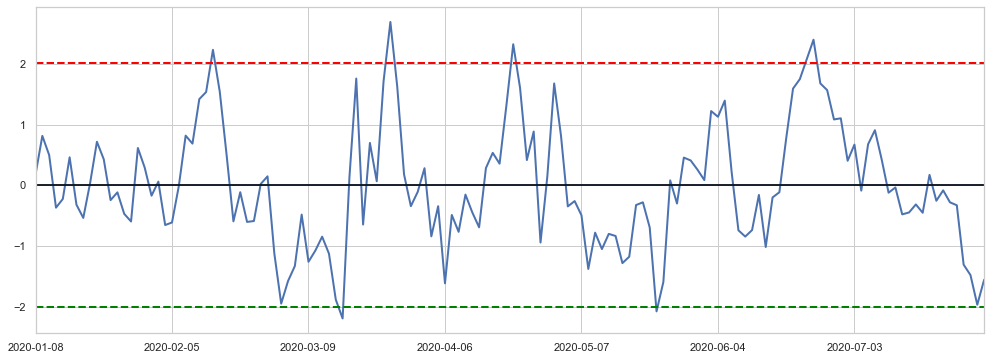

In [15]:
y_symbol = 'BBSE3'
x_symbol = 'ITSA4'
period = 140
print('{}: {} / {}: {}'.format(y_symbol, data[y_symbol][0], x_symbol, data[x_symbol][0]))
mult.plot_residue(mult.residue(data[y_symbol], data[x_symbol], period))

In [50]:
class BackTest(object):
    def __init__(self):
        self.counter_stoploss=0
        self.counter_takeprofit=0
        self.counter_takeprofit=0
        self.counter_oper=0
        self.counter_zerado=0
        self.day_start=None
        self.type_trade=0 #0-Nada; 1-Short; 2-Long
        
        self.finance_gain=0
        self.finance_loss=0
        self.finance_zerar_loss=0
        self.finance_zerar_gain=0
        self.x_price=0
        self.y_price=0
        
    def execute(self, desv_input=2, desv_stop=3, period=100):
        days = data.index[::-1].tolist()
        for day in days:
            test = data[data.index <= day]
            if (len(test) < period):
                continue

            if (self.day_start == None):
                self.day_start = day

            self.y_values, self.x_values = mult.get_values(test[y_symbol], test[x_symbol], period)
            resid = mult.residue(self.y_values, self.x_values, period)
            z_resid = mult.zscore(resid)
            
            check = mult.check_cointegration(self.y_values, self.x_values, period)
            if(check['is_stationary']==False):
                if(self.zerar()):
                    print('Zerado: {}'.format(day))
                continue
            
            # procura por operações
            if (self.check_trade() == False):
                # oper short/long
                if (z_resid[0] >= desv_input):
                    self.short(day)
                    print('Short/Long: {}'.format(day))
                    
                # oper long/short
                if (z_resid[0] <= -desv_input):
                    self.long(day)
                    print('Long/Short: {}'.format(day))

            # gerencia operação aberta
            if (self.check_trade()):
                if (self.isShort()):                    
                    if (z_resid[0] >= desv_stop):# check stop loss
                        self.stop()
                        print('Stop: {}'.format(day))
                    if (z_resid[0] <= 0):# check take profit
                        self.take()
                        print('Take: {}'.format(day))

                if (self.isLong()):                    
                    if (z_resid[0] <= -desv_stop):#  check stop loss
                        self.stop()
                        print('Stop: {}'.format(day))
                    if (z_resid[0] >= 0):# check take profit
                        self.take()
                        print('Take: {}'.format(day))

    def check_trade(self):
        return self.isShort() or self.isLong()
    
    def take(self):
        self.finance_gain += self.calculate()
        self.reset_oper()
        self.counter_takeprofit+=1
            
    def stop(self):
        self.finance_loss += self.calculate()
        self.reset_oper()
        self.counter_stoploss+=1

    def long(self, day):
        self.counter_oper+=1
        self.type_trade = 2 #0-Nada; 1-Short; 2-Long
        self.y_price = self.y_values[0]
        self.x_price = self.x_values[0]

    def short(self, day):
        self.counter_oper+=1
        self.type_trade = 1 #0-Nada; 1-Short; 2-Long
        self.y_price = self.y_values[0]
        self.x_price = self.x_values[0]
        
    def reset_oper(self):
        self.type_trade = 0
    
    def isShort(self):
        return self.type_trade == 1 #0-Nada; 1-Short; 2-Long
    
    def isLong(self):
        return self.type_trade == 2 #0-Nada; 1-Short; 2-Long
    
    def zerar(self):
        if (self.check_trade()):
            self.counter_zerado+=1
            value = self.calculate()
            if(value > 0):
                self.finance_zerar_gain += value
                self.finance_gain += value
            else:
                self.finance_zerar_loss += value
                self.finance_loss += value
                
            self.reset_oper()
            return True
        return False

    def calculate(self):
        lot = 100
        if (self.isLong()):
            long_tot = (self.y_values[0]*lot)-(self.y_price*lot)
            short_tot = (self.x_price*lot)-(self.x_values[0]*lot)
            return (long_tot+short_tot)
            
        if (self.isShort()):
            short_tot = (self.y_price*lot)-(self.y_values[0]*lot)
            long_tot = (self.x_values[0]*lot)-(self.x_price*lot)
            return (long_tot+short_tot)
        return 0

In [51]:
back = BackTest()
back.execute(period=period)
print('---------------------------')
print('Date Start: {}'.format(back.day_start))
print('counter_oper {}'.format(back.counter_oper))
print('counter_takeprofit {}'.format(back.counter_takeprofit))
print('counter_stoploss {}'.format(back.counter_stoploss))
print('counter_zerado {}'.format(back.counter_zerado))
print('---------------------------')
print('finance_loss {}'.format(back.finance_loss))
print('finance_gain {}'.format(back.finance_gain))
print('finance_zerar_gain {}'.format(back.finance_zerar_gain))
print('finance_zerar_loss {}'.format(back.finance_zerar_loss))

Long/Short: 2019-11-18
Zerado: 2019-11-19
Short/Long: 2019-12-18
Take: 2020-01-27
Long/Short: 2020-02-27
Zerado: 2020-03-12
Long/Short: 2020-05-22
Take: 2020-06-19
Long/Short: 2020-07-29
---------------------------
Date Start: 2019-11-18
counter_oper 5
counter_takeprofit 2
counter_stoploss 0
counter_zerado 2
---------------------------
finance_loss -368.55916976928665
finance_gain 471.0872650146482
finance_zerar_gain 29.485702514647983
finance_zerar_loss -368.55916976928665


Days: 10


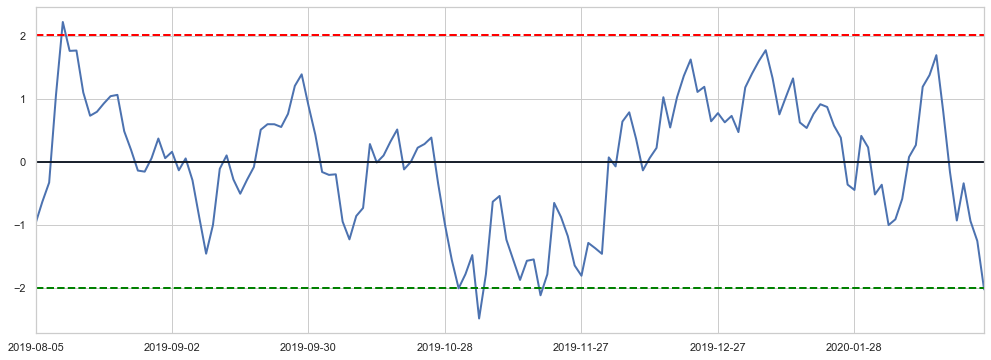

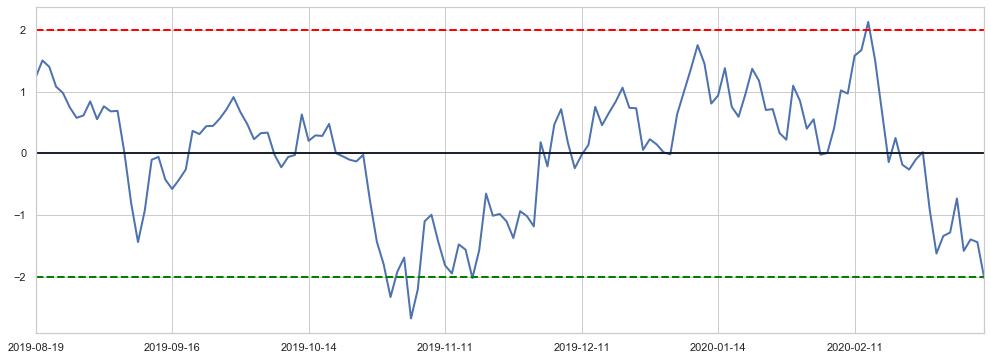

In [35]:
day_start = '2020-02-27'
day_end = '2020-03-12'
test = data[data.index <= day_start]
test_stop = data[data.index <= day_end]
test_simu = data[(data.index >= day_start) & (data.index <= day_end)]

print('Days: {}'.format(abs(len(test)-len(test_stop))))

resid = mult.residue(test[y_symbol], test[x_symbol], period)
mult.plot_residue(resid)
mult.plot_residue(mult.residue(test_stop[y_symbol], test_stop[x_symbol], period))

In [36]:
test_simu[::1][[y_symbol, x_symbol]].to_excel('datasets/backtest/backtest.xlsx')